# Prototype for SGS model calculations

## Preamble

In [1]:
from pathlib import Path
import xarray as xr
import time
from pint import UnitRegistry
ureg = UnitRegistry() #use to parse resolutions

# import os
# os.chdir('src/')

%load_ext autoreload
%autoreload 2
#dev env

In [3]:
import matplotlib.pyplot as plt

# IO

In [5]:
# ext_path = Path('/Volumes/Work/NERC postdoc/')
ext_path = Path('/Users/dv270/NERC_postdoc/online_datatest/')
rel_path = 'CBL/cylc-run/DEBUG'

## Read from Stash files

In [6]:
from sgs_tools.io.um import read_stash_files

#ask for the following fields, if avaialable
required_fields =['u', 'v', 'w', 'theta', 
                  's', 's_1', 's2d', 's4d',
                  'lm', 'qn', 'mm', 'nn',                  
                  'csDelta', 'cs2d', 'cs4d',                
                  'SMAG__VISC_M', 'SMAG__VISC_H',
                  #with dynamic Pr
                  'cs_theta', 'cs_theta_2d', 'cs_theta_4d',
                  'ht', 'tt', 'rf', 'ff',
                  #with Lagrangian averaging
                  'LM', 'MM', 'QN', 'NN',
                  'Tdecorr_momentum',
                  # and dynamic Pr
                  'HT','TT','RF','FF',
                  'Tdecorr_heat',            
                  ]

In [7]:
rose = 'de464'
resolution = '200m'
file_codes = ['r', 'b']

#read UM stasth files: data

simulation_stag = read_stash_files(ext_path / rel_path, f"{rose}_{resolution}a",
                               file_codes=file_codes)

Reading /Users/dv270/NERC_postdoc/online_datatest/CBL/cylc-run/DEBUG/de464_200ma_pr000.nc
Reading /Users/dv270/NERC_postdoc/online_datatest/CBL/cylc-run/DEBUG/de464_200ma_pb000.nc


/Users/dv270/prog/miniconda3/envs/py311_update/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 24
  result = blockwise(
/Users/dv270/prog/miniconda3/envs/py311_update/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 24
  result = blockwise(


### Preprocess simulation (rename and put on a single grid)

In [9]:
from sgs_tools.io.um import (rename_variables,
                             restrict_ds,
                             unify_coords)
from sgs_tools.geometry.staggered_grid import (interpolate_to_grid, 
                                              get_grid_spacing_coord)

In [10]:
%%time
#parse UM stash codes into variable names
simulation_stag = rename_variables(simulation_stag)

#restrict to interesting fields and rename to simple names
simulation_stag = restrict_ds(simulation_stag, fields = required_fields)

# #unify coordinates
simulation_stag = unify_coords(simulation_stag , res= ureg(resolution).to('m').magnitude)

CPU times: user 19.3 ms, sys: 2.36 ms, total: 21.6 ms
Wall time: 21.6 ms


In [11]:
%%time 
#interpolate all vars to a cell-centred grid
centre_dims =['x_centre', 'y_centre', 'z_theta']
simulation = interpolate_to_grid(simulation_stag, centre_dims, drop_coords=True)
#rename spatial dsimensions to 'xyz'
simple_dims = ['x','y','z']
dim_names = {d_new : d_old for d_new, d_old in zip (centre_dims, simple_dims)}
simulation = simulation.rename(dim_names)

CPU times: user 169 ms, sys: 88.2 ms, total: 257 ms
Wall time: 1.13 s


In [12]:
#add horizontal cell size to simulation, after checking that it's constant\
for dim in ['x', 'y']:
    delta = get_grid_spacing_coord(simulation[dim], f'd{dim}')
    assert (all(delta==delta[0])), f'grid is inhomogeneous in direction {dim}'
    simulation[f'd{dim}'] = delta.mean()
if (simulation['dx'] == simulation['dy']):
    simulation['dhor'] = simulation['dx']
else:
    print ('Warning! horiztonally anisotropic grid')

In [13]:
simulation = simulation.rename({'diag11': 's_11', 'diag22' : 's_22', 'diag33' : 's_33',
                                'diag23': 's_23', 'diag13' : 's_13', 'diag12' : 's_12'})

ValueError: cannot rename 'diag11' because it is not a variable or dimension in this dataset

In [11]:
out_path = ext_path / rel_path / 'de464_200ma_000_interp.nc'

In [12]:
simulation.to_netcdf(out_path, mode='w', compute = True)

## Read from pre-processed file

In [15]:
out_path = ext_path / rel_path / 'de464_200ma_000_interp.nc'

In [16]:
#open with explicit chunking -- this allows for gradient calculations?
simulation = xr.open_dataset(out_path, chunks = {'time':10, 'time_0':10, 'z':-1})

In [17]:
simulation

<xarray.Dataset>
Dimensions:                    (t_0: 25, z: 64, y: 128, x: 128, t: 24)
Coordinates: (12/19)
    x_cu                       (x) float64 dask.array<chunksize=(128,), meta=np.ndarray>
    y_cu                       (y) float64 dask.array<chunksize=(128,), meta=np.ndarray>
    rholev_eta_rho             (z) float64 dask.array<chunksize=(64,), meta=np.ndarray>
    min15T0_0                  (t_0) object dask.array<chunksize=(25,), meta=np.ndarray>
    x_cv                       (x) float64 dask.array<chunksize=(128,), meta=np.ndarray>
    y_cv                       (y) float64 dask.array<chunksize=(128,), meta=np.ndarray>
    ...                         ...
    thlev_eta_theta            (z) float64 dask.array<chunksize=(64,), meta=np.ndarray>
    min15T0                    (t) object dask.array<chunksize=(24,), meta=np.ndarray>
  * z                          (z) float64 5.334 9.999 ... 2.816e+03 2.903e+03
    thlev_C_theta              (z) float64 dask.array<chunksize=(64,), meta=np.ndarray>
    thlev_model_level_number   (z) int32 dask.array<chunksize=(64,), meta=np.ndarray>
  * t                          (t) int64 15 30 45 60 75 ... 300 315 330 345 360
Data variables: (12/40)
    u                          (t_0, z, y, x) float64 dask.array<chunksize=(25, 64, 128, 128), meta=np.ndarray>
    v                          (t_0, z, y, x) float64 dask.array<chunksize=(25, 64, 128, 128), meta=np.ndarray>
    w                          (t_0, z, y, x) float64 dask.array<chunksize=(1, 64, 128, 128), meta=np.ndarray>
    theta                      (t_0, z, y, x) float64 dask.array<chunksize=(1, 64, 128, 128), meta=np.ndarray>
    lm                         (t, z, y, x) float64 dask.array<chunksize=(1, 64, 128, 128), meta=np.ndarray>
    qn                         (t, z, y, x) float64 dask.array<chunksize=(1, 64, 128, 128), meta=np.ndarray>
    ...                         ...
    TT                         (t_0, z, y, x) float64 dask.array<chunksize=(1, 64, 128, 128), meta=np.ndarray>
    RF                         (t_0, z, y, x) float64 dask.array<chunksize=(1, 64, 128, 128), meta=np.ndarray>
    FF                         (t_0, z, y, x) float64 dask.array<chunksize=(1, 64, 128, 128), meta=np.ndarray>
    dx                         float64 ...
    dy                         float64 ...
    dhor                       float64 ...
Attributes:
    Conventions:  CF-1.6
    source:       Met Office Unified Model v12.0

## Grid and resolution

(-0.25, 3.0)

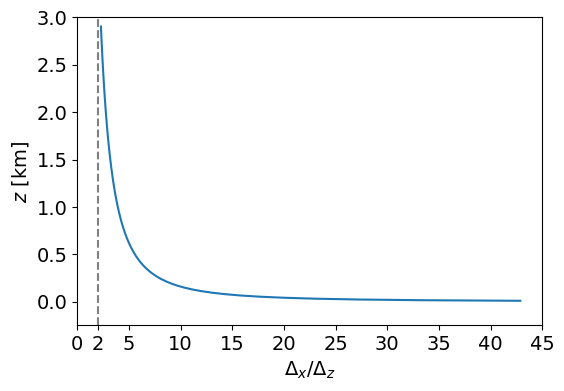

In [21]:
fig = plt.figure(figsize=(6, 4))
dz = simulation['z'].diff('z')
dx = simulation['x'].diff('x').mean()
plt.plot( (dx/dz), dz['z']/1000)
plt.xlabel(r'$\Delta_x/ \Delta_z $', fontsize = 14)
plt.ylabel(r'$z$ [km]', fontsize = 14)
plt.axvline(2, color='gray', ls ='--')
plt.xticks(list(plt.xticks()[0]) + [2], 
           list(plt.xticks()[1]) + ['2'],
           fontsize = 14);
plt.yticks(fontsize=14)
plt.ylim(-0.25, 3)

## Annisotropy of flow

In [75]:
# anisotropy tensor: b_ij = u_i u_j / u_l u_l - 1/3 \delta_{ij}

In [22]:
from sgs_tools.physics.tensor_algebra import tensor_self_outer_product

In [23]:
vel = simulation[['u', 'v', 'w']].to_dataarray(dim = 'c1')

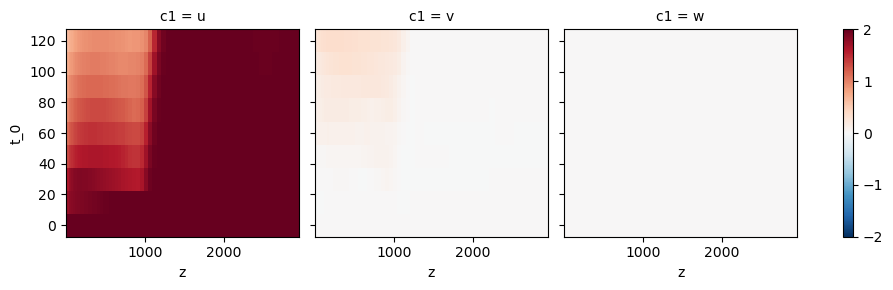

In [24]:
vel.isel(t_0 = slice(None, 9)).mean(['x', 'y']).plot(col = 'c1')

In [215]:
vel_fluct = vel - vel.mean(['x', 'y'])
uu = tensor_self_outer_product(vel_fluct)
bij = (uu).mean(['x', 'y'])/ (0.5*vel_fluct**2).mean(['x', 'y'])
for i in 'uvw':
    bij.loc[{'c1':i, 'c2':i}] -= 1/3    

In [217]:
b_II = (bij * bij).sum(['c1', 'c2'])
bjk = bij.rename({'c2':'c3'})
bki = bij.rename({'c1':'c3'})
b_III = (bij*(bjk*bki).sum('c3')).sum(['c1', 'c2'])

In [218]:
inv = xr.Dataset({"b_III": b_III, "b_II":b_II})

/Users/dv270/prog/miniconda3/envs/py311_update/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


(0.0, 100.0)

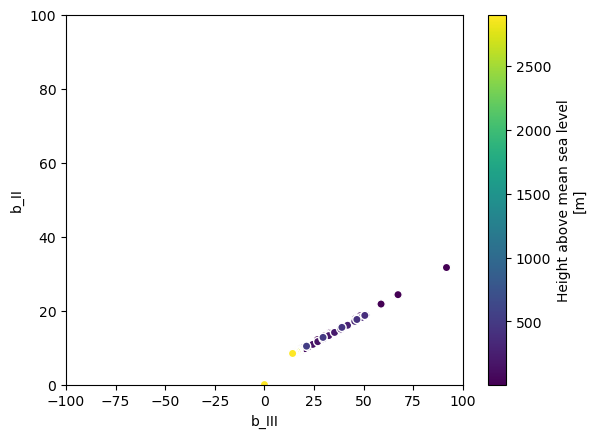

In [240]:
inv.plot.scatter(y='b_II', x = 'b_III', hue = 'z')
plt.xlim(-100, 100)
plt.ylim(0, 100)

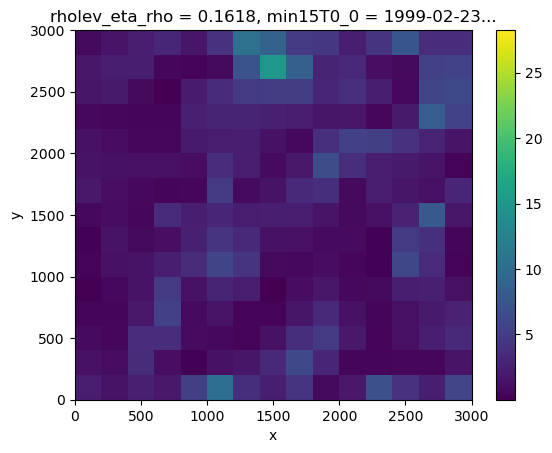

(0.0, 3000.0)

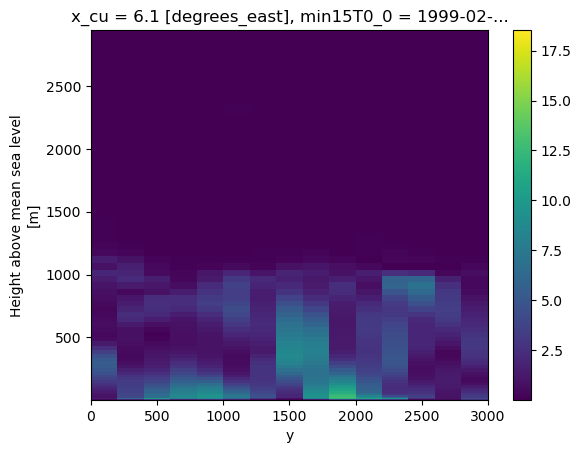

In [242]:
(vel_fluct**2).sum('c1').isel(t_0 = 8).sel(z =500, method='nearest').plot()
plt.ylim(0, 3000)
plt.xlim(0, 3000)
plt.show()
(vel_fluct**2).sum('c1').isel(t_0 = 8).sel(z = simulation.z <3000).isel(x  = 30).plot()
plt.xlim(0, 3000)

In [221]:
selection = inv.isel(t_0 = slice(None, 9)).sel(z = inv.z <=1000)

In [192]:
flat_sel = selection.stack(h = ('x', 'y', 't_0')).sel(h = slice(None, None, 1000))#.plot.scatter(y='b_II', x = 'b_III', hue='z')

/Users/dv270/prog/miniconda3/envs/py311_update/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


(0.0, 100.0)

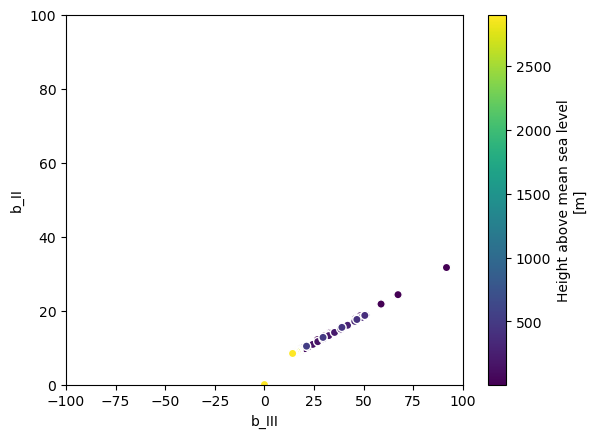

In [226]:
inv.plot.scatter(y='b_II', x = 'b_III', hue = 'z')
plt.xlim(-100, 100)
plt.ylim(0, 100)

/Users/dv270/prog/miniconda3/envs/py311_update/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


(-100.0, 100.0)

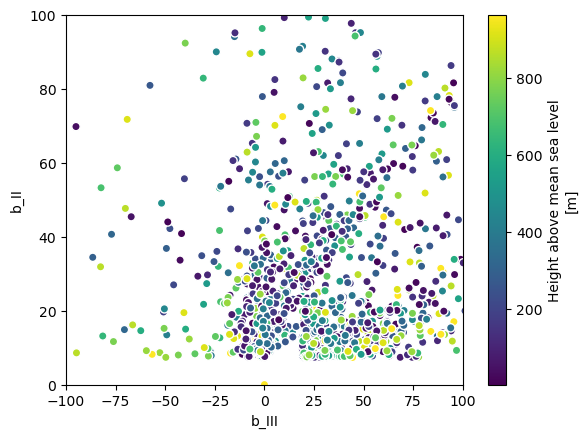

In [206]:
c = selection.sel(x = slice(None, None, 50), y = slice(None, None, 50)).plot.scatter(y='b_II', x = 'b_III', hue = 'z')
c.get_figure().axes[0].set_ylim(0, 100)
c.get_figure().axes[0].set_xlim(-100, 100)

(0.0, 100000.0)

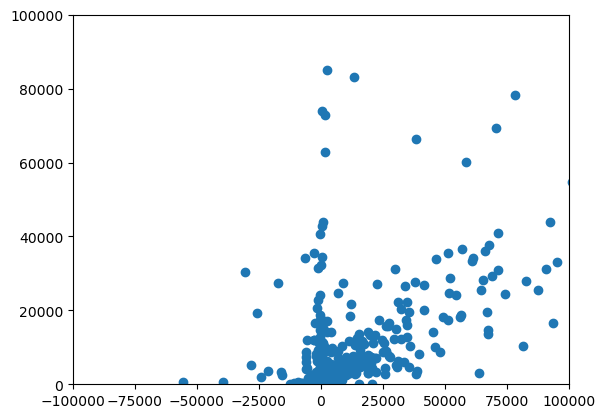

In [190]:
plt.scatter(flat_sel.b_III, flat_sel.b_II)
plt.xlim(-1e5, 1e5)
plt.ylim(0, 1e5)


In [152]:
sel.sel(x= slice(None, None, 8), y= slice(None, None, 8))#.plot.scatter(y='b_II', x = 'b_III', hue='z')

<xarray.Dataset>
Dimensions:                    (x: 16, y: 16, z: 36, t_0: 9)
Coordinates: (12/17)
    x_cu                       (x) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    y_cu                       (y) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    rholev_eta_rho             (z) float64 dask.array<chunksize=(36,), meta=np.ndarray>
    min15T0_0                  (t_0) object dask.array<chunksize=(9,), meta=np.ndarray>
    x_cv                       (x) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    y_cv                       (y) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    ...                         ...
    x_theta                    (x) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    y_theta                    (y) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    thlev_eta_theta            (z) float64 dask.array<chunksize=(36,), meta=np.ndarray>
  * z                          (z) float64 5.334 9.999 16.0 ... 912.0 962.0
    thlev_C_theta              (z) float64 dask.array<chunksize=(36,), meta=np.ndarray>
    thlev_model_level_number   (z) int32 dask.array<chunksize=(36,), meta=np.ndarray>
Data variables:
    b_III                      (t_0, z, y, x) float64 dask.array<chunksize=(1, 36, 16, 16), meta=np.ndarray>
    b_II                       (t_0, z, y, x) float64 dask.array<chunksize=(1, 36, 16, 16), meta=np.ndarray>

In [135]:
inv.mean(['x']).b_II.size

204800

# Compute dynamic Smagorinsky model coefficient at one scale
* TODO -- try to incroporate monc_utils

In [26]:
from sgs_tools.geometry.staggered_grid import compose_vector_components_on_grid
from sgs_tools.physics.fields import strain_from_vel

## Momentum coefficient

In [30]:
from sgs_tools.sgs.filter import IdentityFilter, box_kernel, Filter, weight_gauss_3d
from sgs_tools.sgs.smagorinsky import SmagorinskyVelocityModel
# from sgs_tools.sgs.dynamic_model import GermanoIdentity


In [29]:
%%time
#ensure velocity components are co-located
simple_dims = ['x', 'y', 'z'] # coordinates already exist in simulation
vel = compose_vector_components_on_grid([simulation['u'], simulation['v'], simulation['w']],
                                        simple_dims, name = 'vel',
                                        vector_dim = 'c1')

CPU times: user 8.29 ms, sys: 11.3 ms, total: 19.6 ms
Wall time: 22.2 ms


In [19]:
%%time
#Smagorinsky momentum model
sij = strain_from_vel(vel, space_dims= simple_dims,
                      vec_dim = 'c1', new_dim = 'c2', incompressible =True,
                      )
SmagVel = SmagorinskyVelocityModel(vel, sij, dx = simulation['dhor'])
# del sij

CPU times: user 318 ms, sys: 4.08 ms, total: 322 ms
Wall time: 327 ms


In [20]:
%%time
from sgs_tools.physics.tensor_algebra import grad_vector, traceless, symmetrise
from sgs_tools.physics.staggered_grid import grad_vec_on_grid

#compute grad vel
Aij = grad_vec_on_grid(simulation_stag[['u', 'v', 'w']].rename({'z_theta' : 'z_centre', 'z_rho': 'z_face'}),
                       ['x_centre', 'y_centre', 'z_centre'], new_dim_name = ['c1', 'c2']).sortby(['c1', 'c2'])
#rename coordinates
aij = Aij
aij['c1'] = [1,2,3]
aij['c2'] = [1,2,3]
sij_staggered = traceless(symmetrise(aij,  ['c1', 'c2']),  ['c1', 'c2']).rename({f'{k}_centre': k for k in 'xyz'})
SmagVel_staggered = SmagorinskyVelocityModel(vel, sij_staggered, dx = simulation['dhor'])
#free some memory
# del Aij, aij, sij_staggered

CPU times: user 6.11 s, sys: 4.42 s, total: 10.5 s
Wall time: 11.4 s


Text(0.5, 1.01, 'M box')

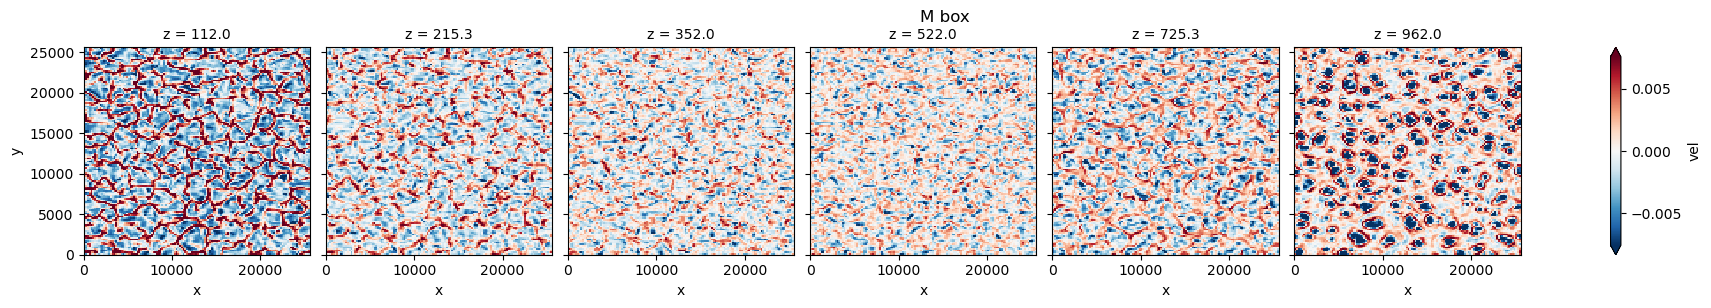

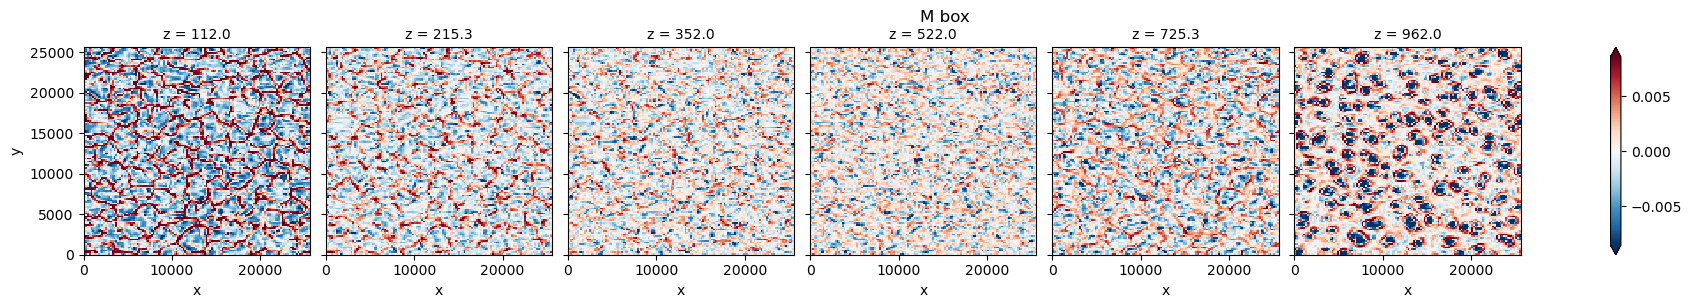

In [22]:
z_slice = slice(10,40, 5)
t_slice = slice(4, 5)
c1 = 2
c2 = 2

sij.isel(c1 = c1, c2 = c2, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
plt.suptitle("M box", y = 1.01)

sij_staggered.isel(c1 = c1, c2 = c2, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
plt.suptitle("M box", y = 1.01)


# sij.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
# plt.suptitle("M box", y = 1.01)

# Mij_gauss.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
# plt.suptitle("M gauss", y = 1.01)

# Lij_box.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
# plt.suptitle("L box", y = 1.01)

# Lij_gauss.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
# plt.suptitle("L gauss", y = 1.01)


In [16]:
%%time
from sgs_tools.physics.tensor_algebra import grad_vector_lin
sij_lin = strain_from_vel(vel, space_dims= simple_dims,
                      vec_dim = 'c1', new_dim = 'c2', incompressible =True,
                          grad_operator = grad_vector_lin
                      )
SmagVel_lin = SmagorinskyVelocityModel(vel, sij_lin, dx = simulation['dhor'])
del sij_lin

CPU times: user 1.11 s, sys: 2.6 s, total: 3.71 s
Wall time: 4.94 s


In [23]:
box_3delta_hor = Filter(box_kernel([3,3]), ['x','y'])
box_5delta_hor = Filter(box_kernel([5,5]), ['x','y'])
gauss_3delta_hor = Filter(weight_gauss_3d, ['x','y'])

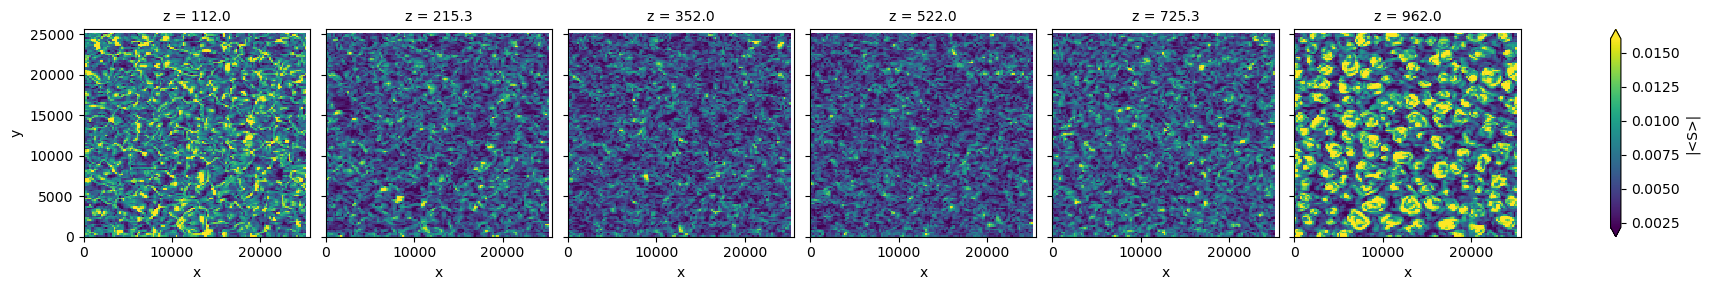

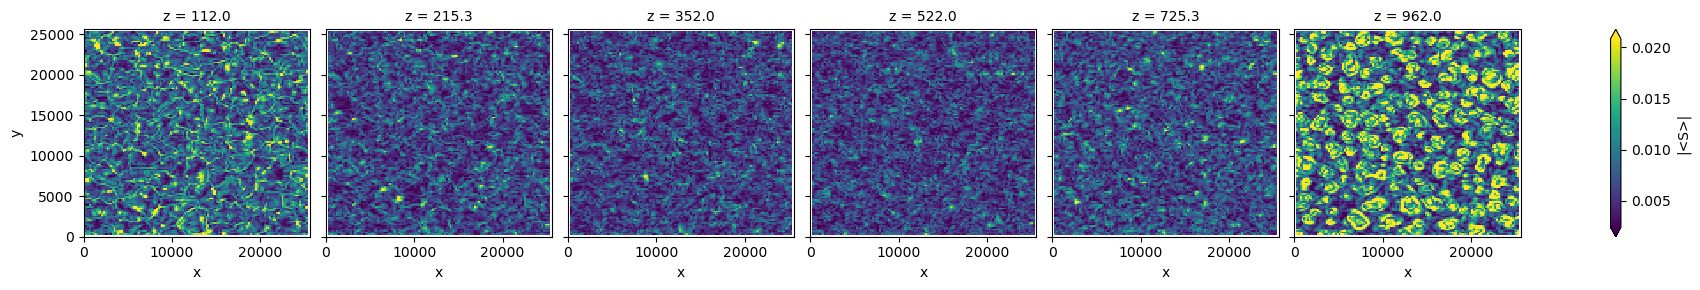

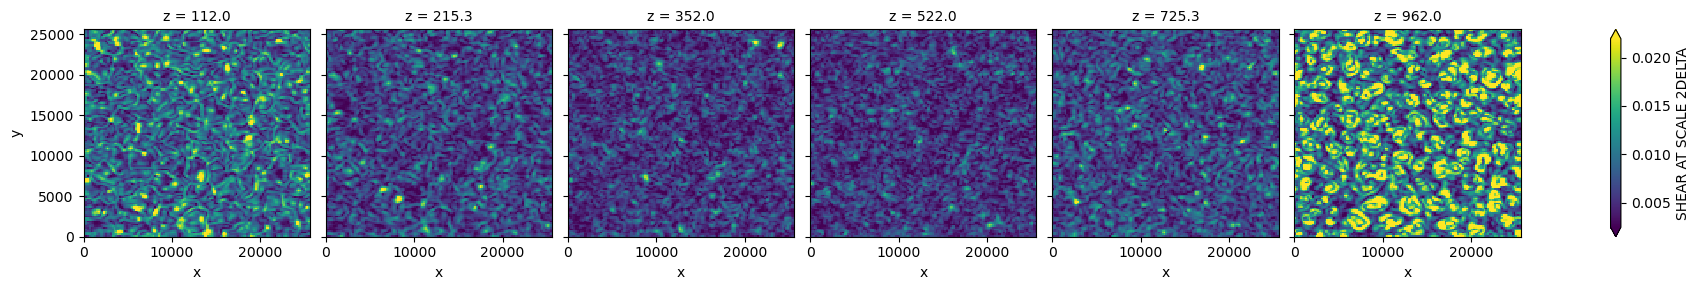

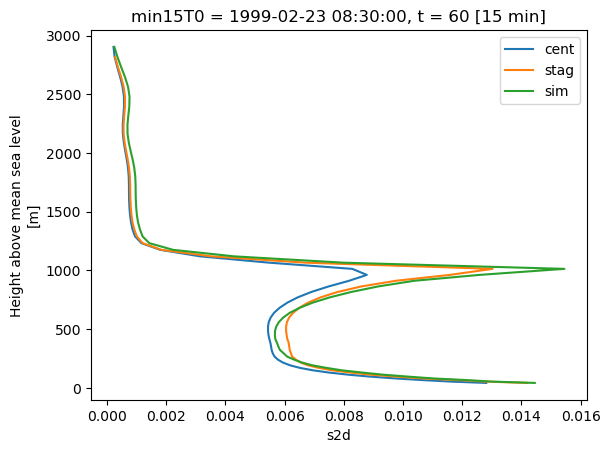

In [33]:
#compare with diagnostin snorm
for Smag in SmagVel, SmagVel_staggered:
    snorm_3deltar = Smag.snorm(gauss_3delta_hor)
    snorm_3deltar.isel(t_0 = slice(4, 5), z = slice(10,40, 5)).plot(col='z',robust=True, add_colorbar=True)
    plt.show()
simulation['s2d'].isel(t = slice(3, 4), z = slice(10,40, 5)).plot(col='z',robust=True, add_colorbar = True) 
plt.show()

for Smag, lbl in zip([SmagVel, SmagVel_staggered], ['cent', 'stag']):
    snorm_3deltar = Smag.snorm(gauss_3delta_hor) 
    snorm_3deltar.isel(t_0 = slice(4, 5), z = slice(5, None)).mean(['x', 'y']).plot(y = 'z', label = lbl)
simulation['s2d'].isel(t = slice(3, 4), z = slice(5, None)).mean(['x', 'y']).plot(y='z', label ='sim') 
plt.legend()
plt.show()

# print(simulation['s2d'].isel(t=-1).t.data)
# print(snorm_3deltar.isel(t_0=-1).t_0.data)

# print(simulation['s2d'].isel(t=-1).t.data)
# print(snorm_3deltar.isel(t_0=-1).t_0.data)

plt.show()

In [34]:
%%time
#compute Germano tensors
# tau_ij = SmagVel.sgs_tensor() # just for reference
# Mij_box = SmagVel.M_Germano_tensor(box_3delta_hor)
# Lij_box = SmagVel.L_Germano_tensor(box_3delta_hor)

Mij_gauss = SmagVel.M_Germano_tensor(gauss_3delta_hor)
Lij_gauss = SmagVel.L_Germano_tensor(gauss_3delta_hor)

CPU times: user 61.3 ms, sys: 4.94 ms, total: 66.2 ms
Wall time: 66 ms


Text(0.5, 1.01, 'L gauss')

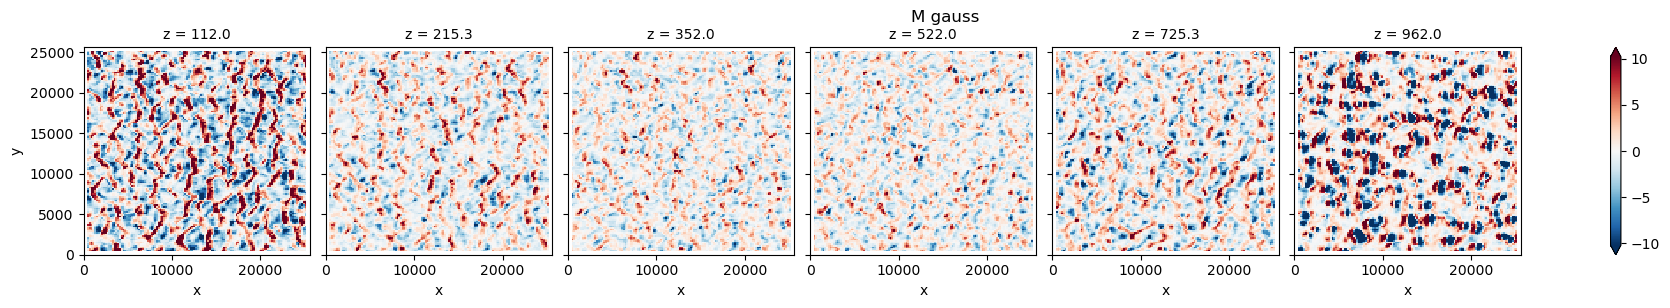

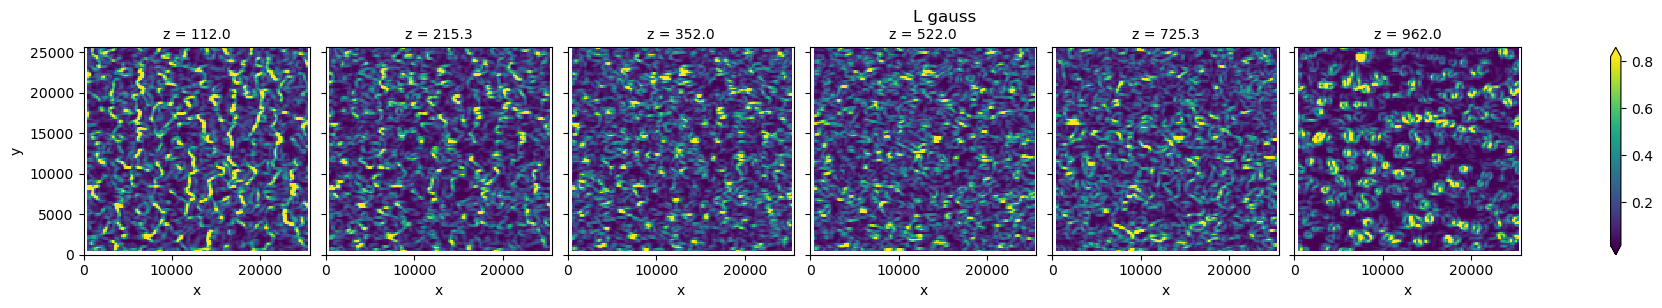

In [35]:
z_slice = slice(10,40, 5)
t_slice = slice(4, 5)

# tau_ij.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
# plt.suptitle("tau grid", y = 1.01)

# Mij_box.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
# plt.suptitle("M box", y = 1.01)

Mij_gauss.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
plt.suptitle("M gauss", y = 1.01)

# Lij_box.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
# plt.suptitle("L box", y = 1.01)

Lij_gauss.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
plt.suptitle("L gauss", y = 1.01)


In [36]:
%%time
#compute Germano tensors from staggered
# tau_ij_stag = SmagVel_staggered.sgs_tensor() # just for reference
# Mij_stag_box = SmagVel_staggered.M_Germano_tensor(box_3delta_hor)
# Lij_stag_box = SmagVel_staggered.L_Germano_tensor(box_3delta_hor)

Mij_stag_gauss = SmagVel_staggered.M_Germano_tensor(gauss_3delta_hor)
Lij_stag_gauss = SmagVel_staggered.L_Germano_tensor(gauss_3delta_hor)

CPU times: user 13.9 s, sys: 4.63 s, total: 18.5 s
Wall time: 21.4 s


Text(0.5, 1.01, 'L gauss')

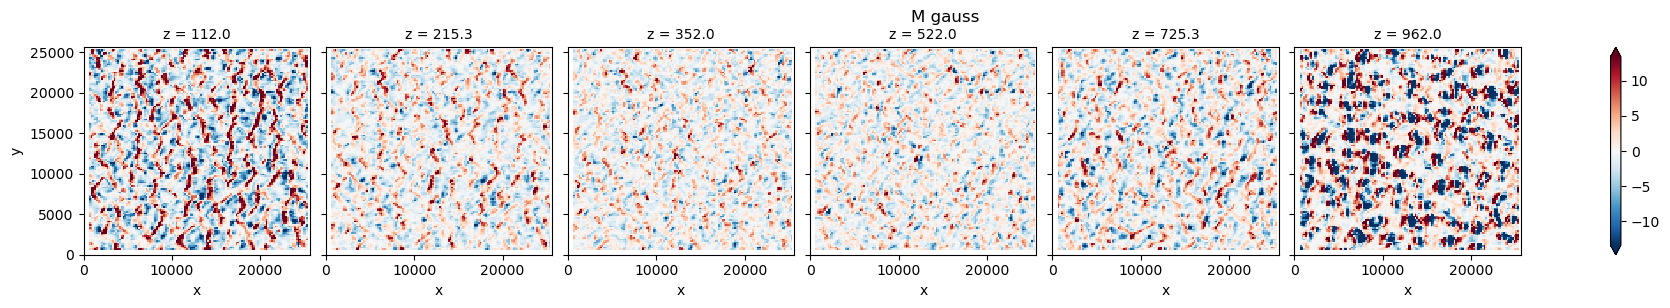

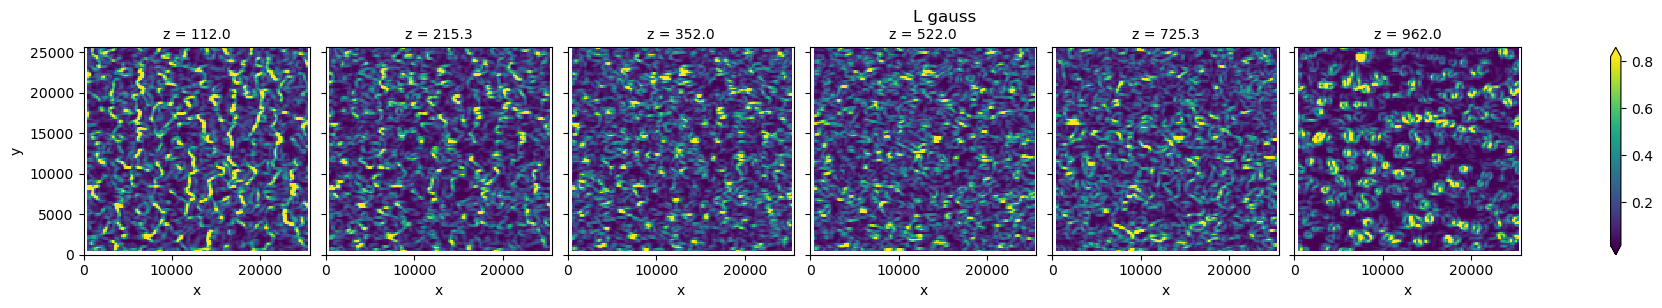

In [37]:
z = slice(10,40, 5)
t_slice = slice(4, 5)

# tau_ij_stag.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
# plt.suptitle("tau grid", y = 1.01)

# Mij_stag_box.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
# plt.suptitle("M box", y = 1.01)

Mij_stag_gauss.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
plt.suptitle("M gauss", y = 1.01)

# Lij_stag_box.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
# plt.suptitle("L box", y = 1.01)

Lij_stag_gauss.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
plt.suptitle("L gauss", y = 1.01)


In [37]:
# del tau_ij, tau_ij_stag

$\nu =  -2 C_{il}  S_{jl} C_{li}$

$\nu_{ij} =  -2 \sqrt{C_{il}  S_{lm} S_{mk} C_{ki}}$

#### Isotropic $c_s = \frac{\langle L_{ij} M_{ji} \rangle }{\langle M_{ij} M_{ji} \rangle }$

#### Diagonal $({c_s})_{\alpha} = \frac{\langle L_{i \alpha} M_{\alpha i} \rangle }{\langle M_{i \alpha } M_{\alpha i} \rangle }$, where summation is only over ${i}$

In [38]:
def cs_isotropic(Mij, Lij, regularization_filter):
    contract_dims = ['c1', 'c2']
    MM = xr.dot(Mij, Mij, dims = contract_dims)
    
    #since Lij and Mij are both symmetric we don't need to transpose
    LM = xr.dot(Mij, Lij, dims= contract_dims)
    
    LM_reg = regularization_filter.filter(LM)
    MM_reg = regularization_filter.filter(MM)
    
    return LM_reg / MM_reg

In [39]:
def cs_diagonal(Mij, Lij, regularization_filter):
    #since Lij and Mij are both symmetric w.r.t c1, c2, we can choose either one
    contract_dims = ['c2']
    MM = xr.dot(Mij, Mij, dims = contract_dims)
    
    #since Lij and Mij are both symmetric we don't need to transpose
    LM = xr.dot(Mij, Lij, dims= contract_dims)
    
    LM_reg = regularization_filter.filter(LM)
    MM_reg = regularization_filter.filter(MM)
    
    return  LM_reg / MM_reg

In [40]:
def cs_matrix(Mij, Lij, regularization_filter):
    #since Lij and Mij are both symmetric w.r.t c1, c2, we can choose either one
    contract_dims = ['c2']
    MM = Mij * Mij
    
    #since Lij and Mij are both symmetric we don't need to transpose
    LM = Mij * Lij
    
    LM_reg = regularization_filter.filter(LM)
    MM_reg = regularization_filter.filter(MM)
    
    return  LM_reg / MM_reg

In [41]:
def clipped_ratio (num, denom, epsilon):
    return max(num/max(denom, epsilon), epsilon)

In [42]:
%%time 
cs_iso_gauss = cs_isotropic(Mij_gauss, Lij_gauss, box_3delta_hor)
# cs_iso_box = cs_isotropic(Mij_box, Lij_box, box_3delta_hor)

cs_iso_gauss = cs_iso_gauss.where(cs_iso_gauss>0, 0)
# cs_iso_box = cs_iso_box.where(cs_iso_box>0, 0)

CPU times: user 19.4 ms, sys: 1.74 ms, total: 21.1 ms
Wall time: 20.6 ms


In [43]:
%%time 
cs_stag_iso_gauss = cs_isotropic(Mij_stag_gauss, Lij_stag_gauss, box_3delta_hor)
# cs_stag_iso_box = cs_isotropic(Mij_stag_box, Lij_stag_box, box_3delta_hor)

cs_stag_iso_gauss = cs_stag_iso_gauss.where(cs_stag_iso_gauss>0, 0)
# cs_stag_iso_box = cs_stag_iso_box.where(cs_stag_iso_box>0, 0)

/Users/dv270/prog/miniconda3/envs/py311_update/lib/python3.11/site-packages/dask/array/einsumfuncs.py:234: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


CPU times: user 1.65 s, sys: 287 ms, total: 1.94 s
Wall time: 1.98 s


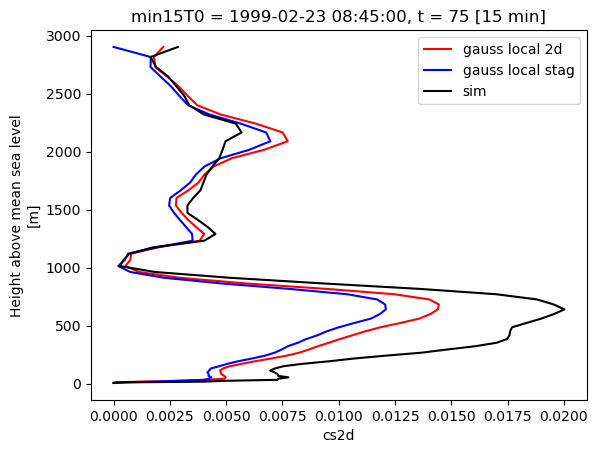

In [44]:
# z = slice(10,40, 5)
t_slice = slice(4, 5)
cs_iso_gauss.isel(t_0 = t_slice).mean(dim=['x', 'y']).plot(y='z',  color = 'r', label='gauss local 2d')
cs_stag_iso_gauss.isel(t_0 = t_slice).mean(dim=['x', 'y']).plot(y='z', color = 'b', label='gauss local stag')

# cs_iso_box.isel(t_0 = t_slice).mean(dim=['x', 'y']).plot(y='z', ls='--', color = 'r', label='box local 2d')
# cs_stag_iso_box.isel(t_0 = t_slice).mean(dim=['x', 'y']).plot(y='z', ls='--', color='b', label='box local stag')

simulation['cs2d'].isel(t = 4).mean(dim=['x','y']).plot(y='z', color = 'k', label='sim')
plt.legend()

In [45]:
%%time 
cs_diag_gauss = cs_diagonal(Mij_gauss, Lij_gauss, box_3delta_hor)
# cs_diag_box = cs_diagonal(Mij_box, Lij_box, box_3delta_hor)

cs_diag_gauss = cs_diag_gauss.where(cs_diag_gauss>0, 0)
# cs_diag_box = cs_diag_box.where(cs_diag_box>0, 0)

CPU times: user 19.3 ms, sys: 2.12 ms, total: 21.4 ms
Wall time: 20.8 ms


In [46]:
%%time 
cs_stag_diag_gauss = cs_diagonal(Mij_stag_gauss, Lij_stag_gauss, box_3delta_hor)
# cs_stag_diag_box = cs_diagonal(Mij_stag_box, Lij_stag_box, box_3delta_hor)

cs_stag_diag_gauss = cs_stag_diag_gauss.where(cs_stag_diag_gauss>0, 0)
# cs_stag_diag_box = cs_stag_diag_box.where(cs_stag_diag_box>0, 0)

/Users/dv270/prog/miniconda3/envs/py311_update/lib/python3.11/site-packages/dask/array/einsumfuncs.py:234: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


CPU times: user 6.02 s, sys: 553 ms, total: 6.58 s
Wall time: 6.88 s


In [66]:
%%time 
cs_matrix_gauss = cs_matrix(Mij_gauss, Lij_gauss, box_3delta_hor)
# cs_matrix_box = cs_matrix(Mij_box, Lij_box, box_3delta_hor)

cs_matrix_gauss = cs_matrix_gauss.where(cs_matrix_gauss>0, 0)
# cs_matrix_box = cs_matrix_box.where(cs_matrix_box>0, 0)

CPU times: user 23.6 s, sys: 8.54 s, total: 32.2 s
Wall time: 42.8 s


In [48]:
%%time 
cs_stag_matrix_gauss = cs_matrix(Mij_stag_gauss, Lij_stag_gauss, box_3delta_hor)
# cs_stag_matrix_box = cs_matrix(Mij_stag_box, Lij_stag_box, box_3delta_hor)

cs_stag_matrix_gauss = cs_stag_matrix_gauss.where(cs_stag_matrix_gauss>0, 0)
# cs_stag_matrix_box = cs_stag_matrix_box.where(cs_stag_matrix_box>0, 0)

CPU times: user 8.43 s, sys: 1.71 s, total: 10.1 s
Wall time: 11.2 s


NameError: name 'cs_matrix_gauss' is not defined

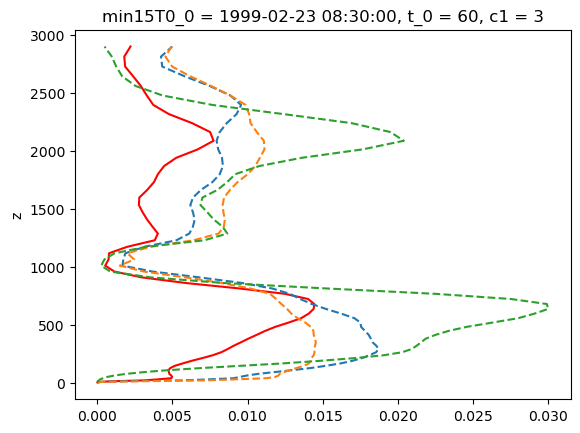

In [47]:
cs_iso_gauss.isel(t_0 = t_slice).mean(dim=['x', 'y']).plot(y='z', ls='-', color = 'r', label='box iso 2d')

for c1 in range(3):
    c, = cs_diag_gauss.isel(t_0 = t_slice, c1 = c1).mean(dim=['x', 'y']).plot(y='z', ls = '--', label = f'c_s idx {c1} ')


for c1 in range(3):
    for c2 in range(c1+1):
        c, = cs_matrix_gauss.isel(t_0 = t_slice, c2 = c2, c1 = c1).mean(dim=['x', 'y']).plot(y='z', ls = ':', label = f'c_s idx {c1} {c2}')

simulation['cs2d'].isel(t = 4).mean(dim=['x','y']).plot(y='z', color = 'gray', label='sim')
plt.legend()

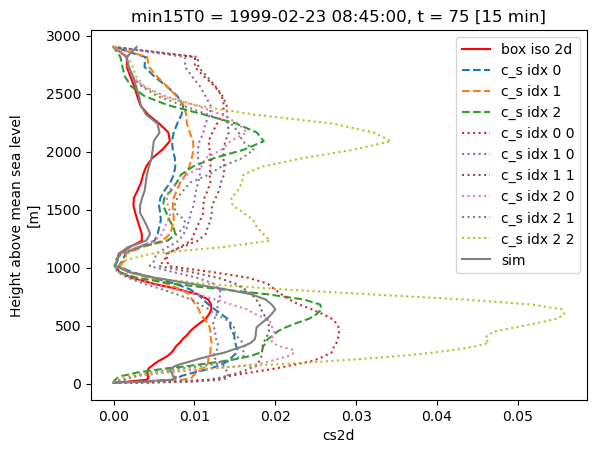

In [72]:
cs_stag_iso_gauss.isel(t_0 = t_slice).mean(dim=['x', 'y']).plot(y='z', ls='-', color = 'r', label='box iso 2d')

for c1 in range(3):
    c, = cs_stag_diag_gauss.isel(t_0 = t_slice, c1 = c1).mean(dim=['x', 'y']).plot(y='z', ls = '--', label = f'c_s idx {c1} ')


for c1 in range(3):
    for c2 in range(c1+1):
        c, = cs_stag_matrix_gauss.isel(t_0 = t_slice, c2 = c2, c1 = c1).mean(dim=['x', 'y']).plot(y='z', ls = ':', label = f'c_s idx {c1} {c2}')

simulation['cs2d'].isel(t = 4).mean(dim=['x','y']).plot(y='z', color = 'gray', label='sim')
plt.legend()

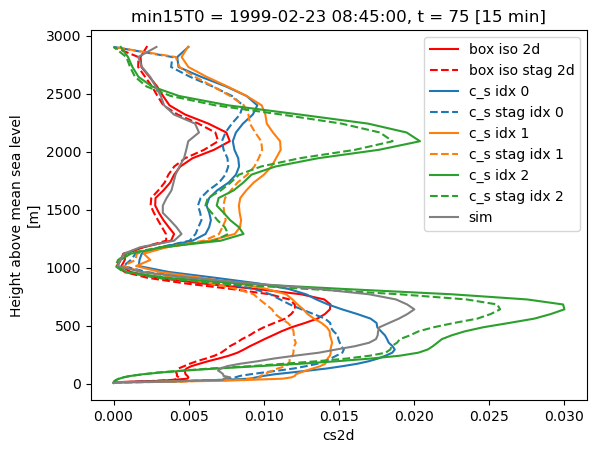

In [60]:
cs_iso_gauss.isel(t_0 = t_slice).mean(dim=['x', 'y']).plot(y='z', ls='-', color = 'r', label='box iso 2d')
cs_stag_iso_gauss.isel(t_0 = t_slice).mean(dim=['x', 'y']).plot(y='z', ls='--', color='r', label='box iso stag 2d')

for c1 in range(3):
    c, = cs_diag_gauss.isel(t_0 = t_slice, c1 = c1).mean(dim=['x', 'y']).plot(y='z', label = f'c_s idx {c1} ')
    cs_stag_diag_gauss.isel(t_0 = t_slice, c1 = c1).mean(dim=['x', 'y']).plot(y='z', ls = '--',  color = c.get_color(), label = f'c_s stag idx {c1} ')

simulation['cs2d'].isel(t = 4).mean(dim=['x','y']).plot(y='z', color = 'gray', label='sim')
plt.legend()

In [ ]:
cs_stag_diag_gauss.isel(t = slice).mean(dim=['x', 'y']).plot(row='c1',robust=True)

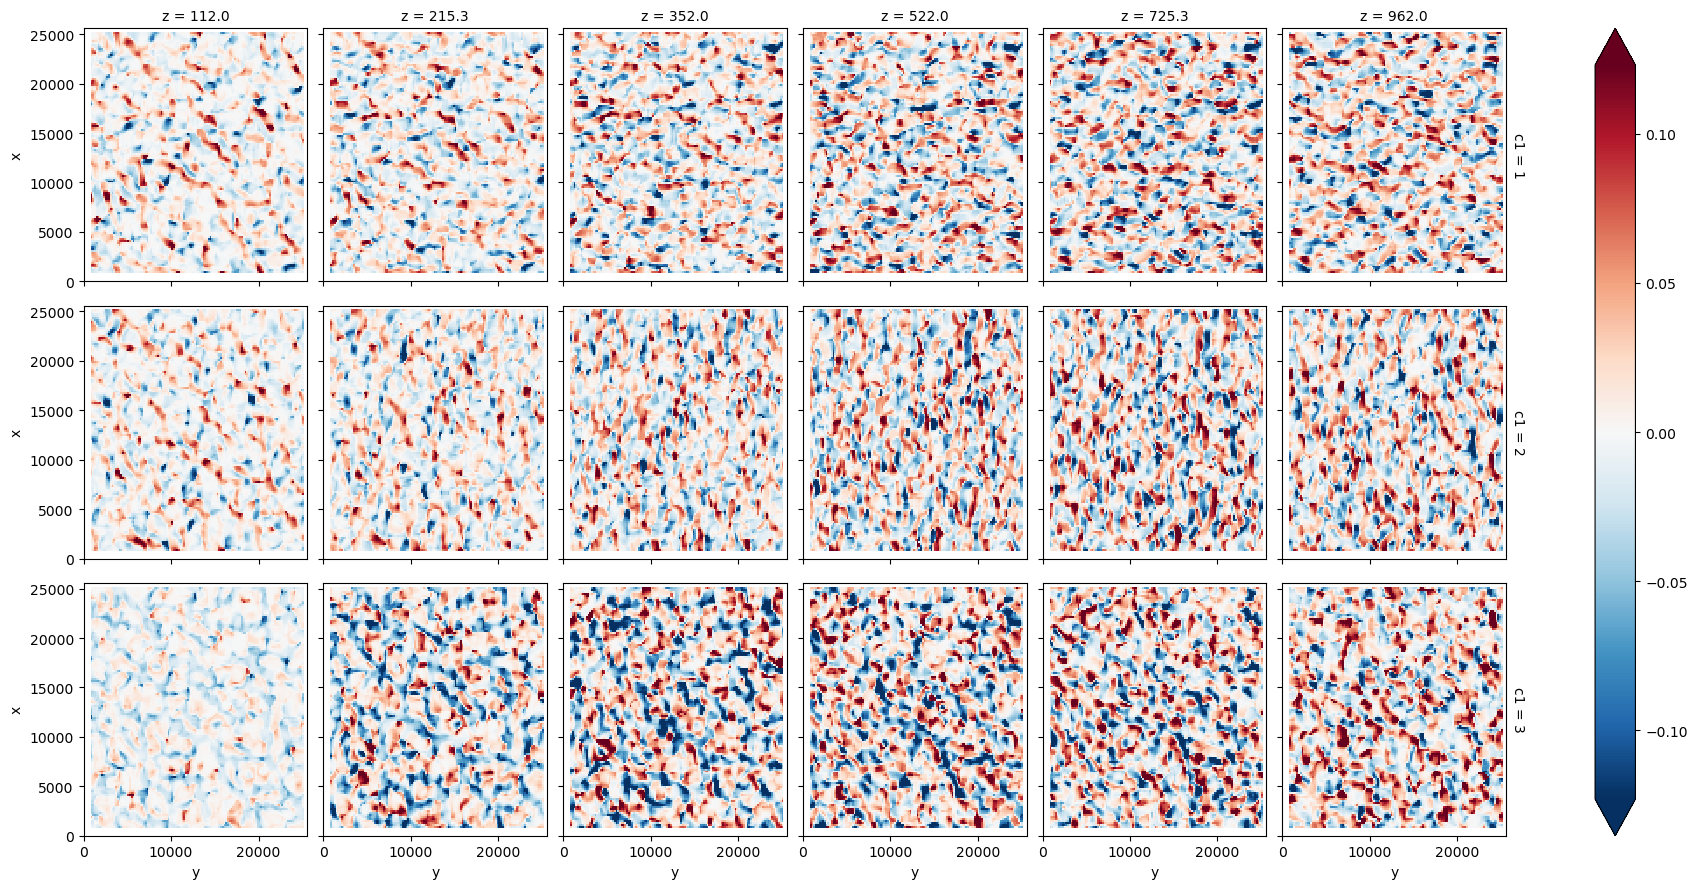

In [135]:
cs_diag_box.isel(t_0 = -1, z = slice(10,40, 5)).plot(col='z',row='c1',robust=True)

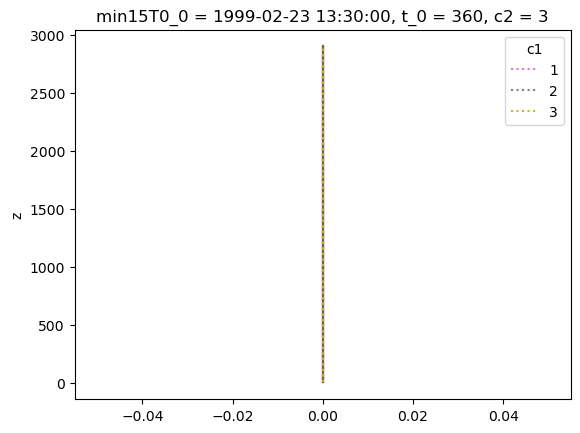

In [88]:
cs_matrix_gauss.isel(t_0 = -1, c2 = 0).mean(dim=['x', 'y']).plot(y='z', hue = 'c1', ls='--')
cs_matrix_gauss.isel(t_0 = -1, c2 = 1).mean(dim=['x', 'y']).plot(y='z', hue = 'c1', ls='-')
cs_matrix_gauss_clipped.isel(t_0 = -1, c2 = 2).mean(dim=['x', 'y']).plot(y='z', hue = 'c1', ls=':')

In [91]:
cs_diag_box_clipped.isel(t_0 = -1).mean(dim=['x', 'y']).plot(y='z', hue = 'c1', ls='--')
cs_iso_box_clipped.isel(t_0 = -1).mean(dim=['x', 'y']).plot(y='z', color='gray', ls=':')
# # cs_iso_gauss.isel(t_0 = -1).mean(dim=['x', 'y']).plot(y='z', color = 'b', label='gauss local')

# cs_iso_box_clipped.isel(t_0 = -1).mean(dim=['x', 'y']).plot(y='z', ls='--', color = 'r', label='box local clipped')
# # cs_iso_box.isel(t_0 = -1).mean(dim=['x', 'y']).plot(y='z', ls='--', color='b', label='box local')


simulation['cs2d'].isel(t=-1).mean(dim=['x','y']).plot(y='z', color = 'k', label='sim')
plt.legend()

NameError: name 'cs_diag_box_clipped' is not defined

In [ ]:
simulation['vertical_heat_flux'] = vertical_heat_flux(simulation['w'], simulation['theta'], ['x', 'y'])

In [28]:
from typing import ClassVar, Union

from  abc import ABC, abstractmethod
from dataclasses import dataclass

import numpy as np
import xarray as xr


## Filtering/coarse graining

In [18]:
from pathlib import Path

In [13]:
import os

In [21]:
os.chdir("sgs_tools/")

In [22]:
Path.cwd()

PosixPath('/Users/dv270/NERC postdoc/Notebooks/SGS_tools/src/sgs_tools')

In [23]:
from sgs.filter import filter_ds

@dataclass
class Filter():
    kernel: xr.DataArray
    def filter(self, field):
        return filter.ds(f, self.kernel)

## Underlying SGS model
* Focus on producing Germano Tensors and Scalars

In [ ]:
class SGSModel(ABC):

@dataclass
class GermanoIdentity(ABC):
    vel: xr.DataArray
    strain: xr.DataArray
    dx: float
    label : ClassVar[str] = 'Momentum'
    
    def Germano_L_tensor(self, field, FilterGridScaleRatio):
        ''' 
        vel_flt = filter_ds(self.vel, filter.kernel)
        resolved = tensor_self_outer_product(vel_flt)    
        filtered = filter_ds(tensor_self_outer_product(vel),filter.kernel)
        
        return filtered - resolved
        ''' 
        return L_Germano_tensor(self.vel, filter.kernel)
    
    def Germano_M_tensor(self, filter, FilterGridScaleRatio):
        ''' 
        snorm = tensor_norm(self.strain, dims=['c1', 'c2'])
        filtered = self.dx**2 * filter_ds(snorm * self.strain, filter.kernel)
        resolved = self.dx**2 * filter_ds(snorm, filter.kernel) * filter_ds(self.strain, filter.kernel)
    
        return filtered - (Filter.kernel.shape[0]-1)**2 * resolved
        '''
        return M_Germano_Smag_tensor(self.vel, filter.kernel)    

In [29]:
#Compute Lilly Scalars from SGS model
class SGSModel(ABC):
    label: str
    
    @abstractmethod
    def Germano_L_tensor(self, filter, FilterGridScaleRatio):
        ...
    
    @abstractmethod
    def Germano_M_tensor(self, filter, FilterGridScaleRatio):
        ...
        
    def Lilly_Scalars(self, filter, FilterGridScaleRatio):
        Mij = self.Germano_L_tensor(filter, FilterGridScaleRatio)
        Lij = self.Germano_M_tensor(filter, FilterGridScaleRatio)
        
        MM = xr.dot(Mij, Mij, dims=['c1', 'c2'])
        LM = xr.dot(Lij, Mij, dims=['c1', 'c2'])
        return xr.dataset({'LM':LM, 'MM':MM})

@dataclass
class SmagorinskyVelocityModel(SGSModel):
    vel: xr.DataArray
    strain: xr.DataArray
    dx: float
    label : ClassVar[str] = 'Momentum'
    
    def Germano_L_tensor(self, filter, FilterGridScaleRatio):
        ''' 
        vel_flt = filter_ds(self.vel, filter.kernel)
        resolved = tensor_self_outer_product(vel_flt)    
        filtered = filter_ds(tensor_self_outer_product(vel),filter.kernel)
        
        return filtered - resolved
        ''' 
        return L_Germano_tensor(self.vel, filter.kernel)
    
    def Germano_M_tensor(self, filter, FilterGridScaleRatio):
        ''' 
        snorm = tensor_norm(self.strain, dims=['c1', 'c2'])
        filtered = self.dx**2 * filter_ds(snorm * self.strain, filter.kernel)
        resolved = self.dx**2 * filter_ds(snorm, filter.kernel) * filter_ds(self.strain, filter.kernel)
    
        return filtered - (Filter.kernel.shape[0]-1)**2 * resolved
        '''
        return M_Germano_Smag_tensor(self.vel, filter.kernel)

@dataclass 
class SmagorinskyThetaModel(SGSModel):
    vel: xr.DataArray
    strain: xr.DataArray
    theta: xr.DataArray
    gradTheta: xr.DataArray
    dx: float
    label : ClassVar[str] = 'Theta'
    
    def Germano_L_tensor(self, filter, FilterGridScaleRatio):        

        vel_flt = filter_ds(self.vel, filter.kernel)
        theta_flt = filter_ds(self.theta, filter.kernel)

        resolved = vel_flt * theta_flt
        filtered = filter_ds(self.theta * self.vel, filter.kernel)
        
        return filtered - resolved
        
    
    def Germano_M_tensor(self, filter, FilterGridScaleRatio):
        '''Model: delta**2 * s_sq * grad_theta '''
        snorm = tensor_norm(self.strain, dims=['c1', 'c2'])        
        filtered = self.dx**2 * filter_ds(snorm * self.gradTheta, filter.kernel)
        resolved = self.dx**2 * filter_ds(snorm, filter.kernel) * filter_ds(self.gradTheta, filter.kernel)
    
        return filtered - (filter.kernel.shape[0]-1)**2 * resolved
        

## Lilly and Meneveau Regularizers to solve overdetermined Germano identity

In [30]:
class LillyRegularizer(ABC):
    @abstractmethod
    def regularize(self, field):
        ...

@dataclass        
class HorizRegularizer(LillyRegularizer):
    filter: Filter
    def regularize(self, field):
        return Filter.filter(field)

@dataclass        
class LagrangeRegularizer(LillyRegularizer):
    timestep: float
    decorr_time: xr.DataArray
    state: xr.DataArray
    update_state: bool = True
    
    def regularize(self, field):        
        weight = self.timestep/(self.decorr_time + self.timestep)
        reg_field = weight * field + (1 - weight) * self.prev_state
        # positive clipping
        reg_field[reg_field < smallp] = smallp
        if self.update_state:
           self.update_state(reg_field)
        return reg_field 
        
    def update_state(self, field):
        self.state = field
        

## Full dynamic models

In [ ]:
#helper functions for the Dynamic models
def clipped_ratio(num, denom, cutoff=1e-7):
    num_clip = np.maximum(num, cutoff)
    denom_clip = np.maximum(denom, cutoff)
    return np.maximum(num/denom, cutoff)

def pick_LagrangeRegularizer_state(field_lbl, filter_scale, numerator):
    if field_lbl == 'vel':
        if filter_scale == 2:
            if numerator:
                return flm
            else:
                return fmm
        elif filter_scale == 4:
            if numerator:
                return fqn
            else:
                return fnn
        else:
            raise ValueError
    elif field_lbl == 'theta':
        if filter_scale == 2:
            if numerator:
                return fht
            else:
                return ftt
        elif filter_scale == 4:
            if numerator:
                return frf
            else:
                return fff
        else:
            raise ValueError
    else:
        raise ValueError


In [31]:
class DynamicSGSModel():
    @abstractmethod
    def eval(self):
        ...
        
class HorizontalModel(DynamicSGSModel):
    model: SGSModel 
    filter: Filter
    filterscale: float
    regularizer: HorizRegularizer

    def eval(self):
        #assume kernel is square-shaped
        Lilly_Scalars = self.model.Lilly_Scalars(filter, filter.kernel.shape[0])
        
        LM_ave = self.regularizer(Lilly_Scalars['LM'])
        MM_ave = self.regularizer(Lilly_Scalars['MM'])

        return clipped_ratio(LM_ave, MM_ave)
        
class LagrangianModel(DynamicSGSModel):
    def __init__(model: SGSModel, filter: Filter, filterscale: float,
                 timestep: float, decorr_time: xr.DataArray = None,
                 evolving_state: bool = True):
        
        self.model = model
        self.filter = filter
        self.filterscale = filterscale 
        
        #link regularizers to global states
        #assume filter kernel is square-shaped
        state_top = pick_LagrangeRegularizer_state(model.lbl, filter.kernel.shape[0]-1, True)
        state_bot = pick_LagrangeRegularizer_state(model.lbl, filter.kernel.shape[0]-1, False, evolving_state)
        if decorr_time is None:
            decorr_time = self.decorr_time()
            
        self.regularizer_top = LagrangeRegularizer(timestep, decorr_time, state_top, evolving_state)
        self.regularizer_bot = LagrangeRegularizer(timestep, decorr_time, state_bot, evolving_state)

    def eval(self):
        #assume kernel is square-shaped
        Lilly_Scalars = self.model.Lilly_Scalars(filter, filter.kernel.shape[0])
        
        LM_ave = self.regularizer_top(Lilly_Scalars['LM'])
        MM_ave = self.regularizer_bot(Lilly_Scalars['MM'])

        return clipped_ratio(LM_ave, MM_ave)

    def self_decorr_time(self):
        flm = pick_LagrangeRegularizer_state(self.model.label, (self.filter.kernel.shape[0] -1), True)
        fmm = pick_LagrangeRegularizer_state(self.model.label, (self.filter.kernel.shape[0] -1), False)
        if self.model.label == "Momentum":        
            return vel_decorr_time(flm, fmm, self.model.dx)
        elif self.model.label == "Theta":
            tref = self.model.theta.std(dims=['x1','x2'])
            return temp_decorr_time(flm, fmm, tref, self.model.dx)
            


class TwoScaleDynamicSGSModel():
    model1: DynamicSGSModel
    model2: DynamicSGSModel
    def eval(self):
        cs1 = self.model1.eval()
        cs2 = self.model2.eval()
        return cs1**2/cs2

In [32]:
#Lagrangian decorrelation time scales 
#Momentum/velocity
def vel_decorr_time(flm, fmm, dx):
    #ad hoc scale factor from  Meneveau Lund Cabot, 1996, JFM
    scale_factor = 1.5
    pos_cutoff = 1e-12
    t = np.maximum(flm * fmm, pos_cutoff)
    return scale_factor * dx / t**(1/8)
#Heat/theta
def temp_decorr_time(flm, fmm, ref, dx):
    #ad hoc scale factor from  Meneveau Lund Cabot, 1996, JFM
    scale_factor = 1.5
    pos_cutoff = 1e-12
    t = np.maximum(flm * fmm, pos_cutoff)    
    return scale_factor * dx * ref / t**(1/4)

In [33]:
#DynamicSGSModelFactory
from globals import weight_box, weight_gauss_3d, weight_gauss_5d
def DynamicSGSModelFactory(lagrange_flag, twoscale_flag, external_time_scale, SGSModel):            
    if not lagrange_flag:
        RunningAverage = Filter(weight_box)
        regularizer = HorizRegularizer(RunningAverage)

        filter = Filter(weight_gauss_3d)
        dynamic_model = HorizontalModel(SGSModel, filter, (filter.kernel.shape[0] -1)**2,
                                        regularizer)
        if twoscale_flag:
            filter2 = Filter(weight_gauss_5d)
            dynamic_model2 = HorizontalModel(SGSModel, filter2, (filter2.kernel.shape[0] -1)**2,
                                             regularizer)
    
            dynamic_model = TwoScaleDynamicSGSModel(dynamic_model, dynamic_model2)                 
                
    else:
        filter = Filter(weight_gauss_3d)
        if external_time_scale:            
            decorr_time = external_time_scale
        else:
            
            decorr_time = vel_decorr_time(pick_LagrangeRegularizer_state(SGSModel.label, (filter.kernel.shape[0] -1), True),
                                          pick_LagrangeRegularizer_state(SGSModel.label, (filter.kernel.shape[0] -1), False), 
                                          SGSModel.dx)
        dynamic_model = LagrangianModel(SGSModel, filter, (filter.kernel.shape[0] -1)**2,
                                        decorr_time,
                                        timestep, evolving_state = True)
        if twoscale_flag:
            filter2 = Filter(weight_gauss_5d)
            decorr_time = vel_decorr_time(pick_LagrangeRegularizer_state(SGSModel.label, (filter2.kernel.shape[0] -1), True),
                                           pick_LagrangeRegularizer_state(SGSModel.label, (filter2.kernel.shape[0] -1), False),
                                           SGSModel.dx)
            dynamic_model2 = LagrangianModel(SGSModel, filter2, (filter2.kernel.shape[0] -1)**2,
                                             decorr_time,
                                             timestep, evolving_state = True)
            dynamic_model = TwoScaleDynamicSGSModel(dynamic_model, dynamic_model2)  
            
    return dynamic_model


SyntaxError: invalid syntax (3300112974.py, line 24)

## Main executatble -- putting everything together and testing

In [21]:
#global cache/state
from SimpleFlows.SimpleShear import SimpleShear, ScalarGradient
from SimpleFlows.Geometry import UniformCartesianGrid
from globals import grad_vel, rate_of_strain

#timing 
timestep = 5 #mins
timestetnumber = 3
#geometry
grid = UniformCartesianGrid()
grid_shape = [6,6,6]

#base fields
shear_vel = SimpleShear(grid, 0, 1, 1)
vel = shear_vel.velocity(grid_shape)
theta = ScalarGradient(grid, 2, 0.5).field(grid_shape)

#simple gradients
strain = rate_of_strain(grad_vel(vel, ndim = 3))
grad_theta = grad_vel(theta, ndim = 3)

#Cached accumulated state 
flm = xr.zeros_like(theta)
fmm = xr.zeros_like(theta)
fqn = xr.zeros_like(theta)
fnn = xr.zeros_like(theta)

fht = xr.zeros_like(theta)
ftt = xr.zeros_like(theta)
frf = xr.zeros_like(theta)
ffs = xr.zeros_like(theta)

In [5]:
#model options -- logic branches
lagrange_flag = True
one_time_scale = True
twoscale_flag = False
Pr_flag = False

In [20]:
#main Dynamic Modelling routine
strain = xr.DataArray(np.zeros([6,6,6,6]))
grad_thetav = xr.DataArray(np.zeros([6,6,6,3]))
dx = 1

#Smagorinsky model
VelModel = SmagorinskyVelocityModel(vel, strain, dx)
ThetaModel = SmagorinskyThetaModel(vel, strain, theta, grad_theta, dx)

cs_model = DynamicSGSModelFactory(lagrange_flag, twoscale_flag, VelModel)
cs = cs_model%eval()

if Pr_flag:
    ctheta_model = DynamicSGSModelFactory(lagrange_flag, twoscale_flag, ThetaModel)
    ctheta = cs_model%eval()


__NOTE: Missing pieces:__
* Initial states for flm, etc. and Regularizer behaviour -- plug into LagrangianModel.eval() 
* ...?